<a href="https://colab.research.google.com/github/nedlecky/CSC485B/blob/main/CSC485_220_IrisClusterStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC 485B Spring 2023: CSC485_220_IrisClusterStudy
## Try clustering based on the Iris dataset
* SUNY Plattsburgh, Spring 2023
* Dr. Ned Lecky
* nleck001@plattsburgh.edu
* ned@lecky.com


In [1]:
# Create our output directories
from pathlib import Path

OUTPUT_PATH = Path() / "iris_cluster"
IMAGES_PATH = Path() / OUTPUT_PATH / "images"

In [2]:
# Setup and Support Functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import random

# This makes us reproducible (and we can adjust fixed_seed to get different results)
fixed_seed = 1

# Return n random floats between lo and hi as 1-column NumPy matrix
def rand_nlohi(n=1, lo=0, hi=1):
  # This is just a uniform distribution from lo to hi... we can adjust if appropriate in the future
  return (np.random.rand(n) * (hi - lo) + lo).reshape(-1,1)

# Often a good idea as long as we are keeping values near +/- 1... don't need exponential notation
np.set_printoptions(floatmode='fixed', precision=4, suppress=True)
# This will get us all 400 rows printed... which fails past 40 x 2 columns
np.set_printoptions(threshold=sys.maxsize)

# Simple numpy array print with optional push to file
def nprint(m, name='', also_write_file=False):
  print(f"{name} {m.shape} {m.dtype}")
  print(m)
  if also_write_file and name != '':
    fprint(m, name)

# Print numpy array to file (needs name)
def fprint(m, name='', path=OUTPUT_PATH):
  if name != '':
    with open(path /  name, 'w') as f:
      print(f"{name} {m.shape} {m.dtype}", file=f)
      print(m, file=f)
  else:
    print('fprint needs a name!')

# Remove a file and don't complain if it doesn't exist
def remove_file(name):
  try:
    os.remove(name)
  except:
    return

# Delete a directory, recursively removing files and subdirectories
def delete_directory(path):
  if not OUTPUT_PATH.exists():
    return

  print(f"delete_directory({path})")
  for file_name in os.listdir(path):
    # construct full file path
    file = path / file_name
    if os.path.isdir(file):
        print('  found subdirectory', file)
        delete_directory(file)
    elif os.path.isfile(file):
        print('  deleting file', file)
        os.remove(file)
  os.rmdir(path)

# Save a matplotlib figure to a png file
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Makes default plots a bit cleaner
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


In [3]:
# Setup (and clear) output directories
delete_directory(OUTPUT_PATH)

OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

delete_directory(iris_cluster)
  deleting file iris_cluster/expected_count
  deleting file iris_cluster/y_pred
  deleting file iris_cluster/y_pred_raw
  deleting file iris_cluster/X
  deleting file iris_cluster/raw_count
  deleting file iris_cluster/Xy
  deleting file iris_cluster/y
  found subdirectory iris_cluster/images
delete_directory(iris_cluster/images)
  deleting file iris_cluster/images/classification_vs_clustering_plot.png
  deleting file iris_cluster/pred_count


Load the data.

In [4]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
Xy = np.hstack([X,y.reshape(-1,1)])
fprint(X,"X")
fprint(y,"y")
fprint(Xy,"Xy")
print(f"feature_names = {data.feature_names}")
print(f"target_names = {data.target_names}")


feature_names = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
target_names = ['setosa' 'versicolor' 'virginica']


Letr's look at the data in all the different 2D projections.

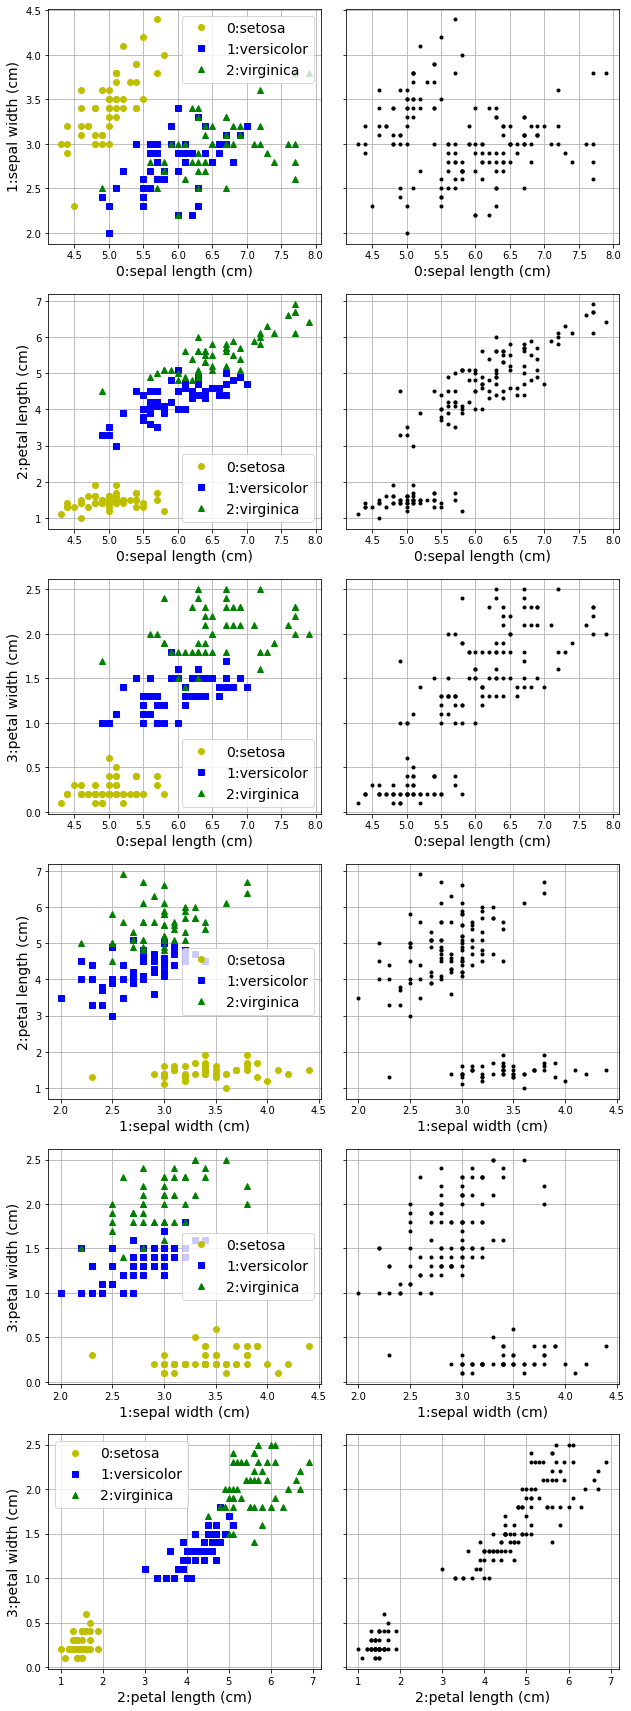

In [5]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
data.target_names

# Let's plot every combo of the 4 features as X vs Y
plt.figure(figsize=(9, 24))
plotnum=1
for i1 in range(0,4):
  for i2 in range(i1+1, 4):
    plt.subplot(6,2,plotnum)
    plt.plot(X[y==0, i1], X[y==0, i2], "yo", label=f"0:{data.target_names[0]}")
    plt.plot(X[y==1, i1], X[y==1, i2], "bs", label=f"1:{data.target_names[1]}")
    plt.plot(X[y==2, i1], X[y==2, i2], "g^", label=f"2:{data.target_names[2]}")
    plt.xlabel(f"{i1}:{data.feature_names[i1]}")
    plt.ylabel(f"{i2}:{data.feature_names[i2]}")
    plt.grid()
    plt.legend()
    plotnum += 1

    plt.subplot(6,2,plotnum)
    plt.scatter(X[:, i1], X[:, i2], c="k", marker=".")
    plt.xlabel(f"{i1}:{data.feature_names[i1]}")
    plt.tick_params(labelleft=False)
    plt.gca().set_axisbelow(True)
    plt.grid()
    plotnum += 1

save_fig("classification_vs_clustering_plot")
plt.show()

Let's try Gaussian Mixture

<ipython-input-6-04760e73a0f7>:16: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(y_pred_raw[y==class_id])


mapping is {1: 0, 2: 1, 0: 2}
n_wrong = 5 / 150  accuracy = 96.67%


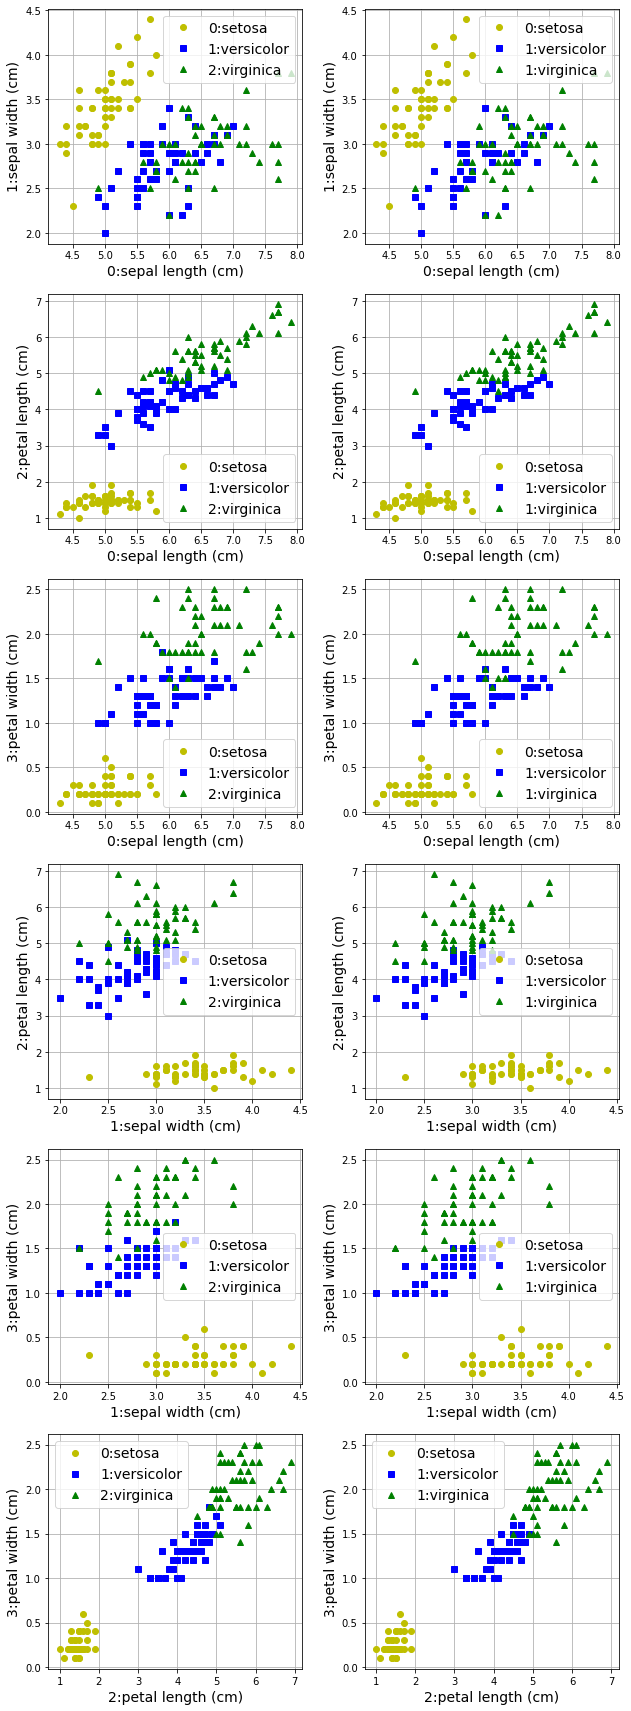

In [6]:
import numpy as np
from scipy import stats
from sklearn.mixture import GaussianMixture

y_pred_raw = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)
fprint(y_pred_raw,"y_pred_raw")

# Cleverness to swap categories based on what each category is most frequently
#  labeled as in y_pred
expected_count = np.array([(y==0).sum(),(y==1).sum(),(y==2).sum()])
raw_count = np.array([(y_pred_raw==0).sum(),(y_pred_raw==1).sum(),(y_pred_raw==2).sum()])
fprint(expected_count,"expected_count")
fprint(raw_count,"raw_count")
mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_pred_raw[y==class_id])
    mapping[mode[0]] = class_id
print(f"mapping is {mapping}")

y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred_raw])
fprint(y_pred,"y_pred")

pred_count = np.array([(y_pred==0).sum(),(y_pred==1).sum(),(y_pred==2).sum()])
fprint(raw_count,"pred_count")

n_wrong = (y!=y_pred).sum()
print(f"n_wrong = {n_wrong} / {len(y)}  accuracy = {100.*(len(y) - n_wrong) / len(y):.2f}%")

# Let's plot the prediction for every combo of the 4 features as X vs Y
plt.figure(figsize=(9, 24))
plotnum=1
for i1 in range(0,4):
  for i2 in range(i1+1, 4):
    plt.subplot(6,2,plotnum)
    plt.plot(X[y==0, i1], X[y==0, i2], "yo", label=f"0:{data.target_names[0]}")
    plt.plot(X[y==1, i1], X[y==1, i2], "bs", label=f"1:{data.target_names[1]}")
    plt.plot(X[y==2, i1], X[y==2, i2], "g^", label=f"2:{data.target_names[2]}")
    plt.xlabel(f"{i1}:{data.feature_names[i1]}")
    plt.ylabel(f"{i2}:{data.feature_names[i2]}")
    plt.grid()
    plt.legend()
    plotnum += 1

    plt.subplot(6,2,plotnum)
    plt.plot(X[y_pred==0, i1], X[y_pred==0, i2], "yo", label=f"0:{data.target_names[0]}")
    plt.plot(X[y_pred==1, i1], X[y_pred==1, i2], "bs", label=f"1:{data.target_names[1]}")
    plt.plot(X[y_pred==2, i1], X[y_pred==2, i2], "g^", label=f"1:{data.target_names[2]}")
    plt.xlabel(f"{i1}:{data.feature_names[i1]}")
    plt.ylabel(f"{i2}:{data.feature_names[i2]}")
    plt.legend()#loc="upper left")
    plt.grid()
    plotnum += 1

save_fig("GaussianMixture Results")
plt.show()